<a href="https://colab.research.google.com/github/GunH-colab/Covid-19-Lockdown-Projects/blob/main/covid_detection_Heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# necessary libraries

import os
import sys
import random
import subprocess
import cv2

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from collections import OrderedDict

import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy.ndimage import binary_dilation
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# for cloning the repo at https://github.com/ieee8023/covid-chestxray-dataset.git

def run_cmd(cmd, stderr = subprocess.STDOUT):
    out = None
    try:
        out = subprocess.check_output([cmd], shell=True, stderr = subprocess.STDOUT, universal_newlines = True)
    except subprocess.CalledProcessError as e:
        print(f'ERROR {e.returncode}: {cmd}\n\t{e.output}', flush=True, file=sys.stderr)
        raise e
    return out

def clone_data(data_root):
    clone_uri = 'https://github.com/ieee8023/covid-chestxray-dataset.git'
    if os.path.exists(data_root):
        assert os.path.isdir(data_root), \
        f'{data_root} should be cloned from {clone_uri}'
    else:
        print('Cloning the covid chestxray dataset. It may take a while\n...\n', flush=True)
        run_cmd(f'git clone {clone_uri} {data_root}')

In [3]:
random_seed= 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = True
batch_size = 64
validation_split = .34
shuffle_dataset = True

In [4]:
# defining directories

data_root = "./data"
mgpath = f'{data_root}/images',
csvpath = f'{data_root}/metadata.csv',

In [5]:
clone_data(data_root)

Cloning the covid chestxray dataset. It may take a while
...



In [6]:
meta = pd.read_csv('/content/data/metadata.csv')

In [7]:
meta['view'].value_counts(dropna = False)

PA           344
AP Supine    234
AP           203
L             84
Axial         68
Coronal       16
AP Erect       1
Name: view, dtype: int64

In [8]:
for x in meta['filename']:
    if x.split('.')[-1]=='gz':
        meta.drop(meta.index[meta['filename']==x], 
                  inplace=True)

In [9]:
new_findings = []

for x in meta['finding']:
    new_findings.append(x.split('/')[-1])

meta['findings'] = new_findings
meta.to_csv('new.csv', index = False)

meta = meta[(meta['findings'] == 'COVID-19') | (meta['findings'] == 'SARS') | (meta['findings'] == 'Pneumocystis') | (meta['findings'] == 'Streptococcus')]
meta = meta[meta['view']=='PA']

In [10]:
meta['findings'].value_counts(dropna=False)

COVID-19         196
Pneumocystis      21
Streptococcus     12
SARS               8
Name: findings, dtype: int64

In [11]:
X_train_val, X_test = train_test_split( meta[meta['findings']=='COVID-19'], test_size = 0.55, random_state = random_seed)
meta.drop(X_test.index, inplace = True)
meta.reset_index(drop = True, inplace = True)

In [12]:
meta['findings'].value_counts(dropna = False)

COVID-19         88
Pneumocystis     21
Streptococcus    12
SARS              8
Name: findings, dtype: int64

In [13]:
dataset_size = len(meta)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [14]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [15]:
# onehot encoding

Labels = np.array(meta['findings']).reshape(len(meta['findings']), 1)
encode = OneHotEncoder()
encode.fit(Labels)
labels_enc = encode.transform(Labels).toarray()

In [16]:
# image data augmentations

transform = transforms.Compose([
                                  transforms.ToPILImage(),
                                  transforms.RandomCrop(224),                              
                                  transforms.ToTensor(),                                                  
                                  transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                              ])

In [17]:
# the classes we have got

class_names = [
                  'COVID-19', 
                  'Pneumocystis',       
                  'Streptococcus',   
                  'SARS'                 
              ]

In [18]:
class ChestXrayDataSet(Dataset):
    def __init__(self, csvpath, mgpath, labels_enc, transform = None):
        self.meta_data = pd.read_csv(csvpath)
        self.root_dir = mgpath
        self.transform = transform
        for x in self.meta_data['filename']:
            if x.split('.')[-1]=='gz':
                self.meta_data.drop(self.meta_data.index[self.meta_data['filename']==x], inplace=True)
        self.new_findings = []

        for x in self.meta_data['finding']:
            self.new_findings.append(x.split('/')[-1])

        self.meta_data['findings'] = self.new_findings
        self.labels = self.meta_data['findings']
    
        self.meta_data = self.meta_data[(self.meta_data['findings'] == 'COVID-19')
                                        |(self.meta_data['findings'] == 'SARS')
                                        |(self.meta_data['findings'] == 'Pneumocystis')
                                        |(self.meta_data['findings'] == 'Streptococcus')]
        self.meta_data = self.meta_data[self.meta_data['view'] == 'PA']
        self.meta_data.drop(X_test.index, inplace = True)
        self.meta_data.reset_index(drop = True, inplace = True)
    
    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir, self.meta_data.loc[idx, 'filename'])
        image = Image.open(img_name).convert('RGB')
        image = np.array(image.resize((256, 256)))
        image = image[:, :, 0]
        image = np.uint8(((np.array(image) / 255).reshape(256, 256, 1)) * 255 * 255)
        image = np.tile(image, 3) 
        label = labels_enc[idx]
        if self.transform is not None:
            image = self.transform(image)
        return image, label, idx

In [19]:
dataset = ChestXrayDataSet(csvpath[0], mgpath[0], labels_enc, transform)

In [20]:
# loading train and validation set

train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)

validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [21]:
def img_display(img):
    img = img*0.229+0.485   # unnormalize (inp = inp*std + mean)
    npimg = img.numpy()[0]
  
    return npimg

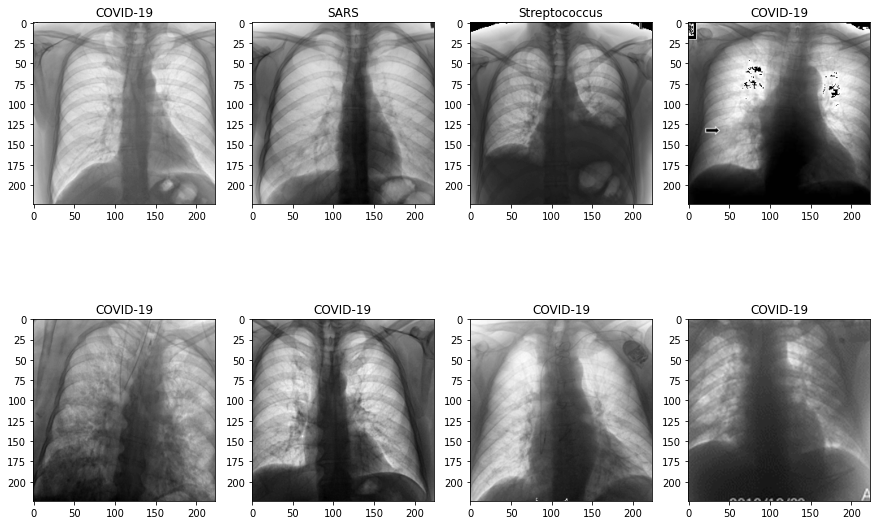

In [22]:
# get some random training images
dataiter = iter(train_loader)
images, labels, id_ = dataiter.next()
# Viewing data examples used for training
fig, axis = plt.subplots(2, 4, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, _ = images[i], labels[i], id_[i]
        ax.imshow(img_display(image),cmap='gray') # add image
        ax.set(title = f"{meta['findings'][_.item()]}") # add label

In [23]:
# construct model
class DenseNet121(nn.Module):
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        ).cuda()
    def forward(self, x):
        x = self.densenet121(x)
        return x

In [24]:
cudnn.benchmark = True
N_CLASSES = 4

In [25]:
# defining metric

def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Detects GPU
print(device)

cuda:0


In [27]:
# initialize and load the model
model = DenseNet121(N_CLASSES)
model = model.cuda(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [28]:
optimizer = optim.Adam(model.parameters(),lr = 0.0007)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.cuda(device)

In [29]:
save_best = 0.0
for epoch in range(75):
    print("Epoch:",epoch)
    running_loss = 0.0
    for batch_idx, (data_, target_,_) in enumerate(train_loader):
        target_ = target_.type(torch.float)
        data_, target_ = data_.cuda(device), target_.cuda(device)
        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # ======== validation ======== 
        # switch to evaluate mode
        # initialize the ground truth and output tensor
        with torch.no_grad():
            model.eval()
            gt = torch.FloatTensor()
            gt = gt.cuda()
            pred = torch.FloatTensor()
            pred = pred.cuda()
            for i, (data_t, target_t,_t) in enumerate(validation_loader):
                target_t = target_t.type(torch.float)
                data_t, target_t = data_t.cuda(device), target_t.cuda(device)
                gt = torch.cat((gt, target_t), 0)
                input_var = Variable(data_t.view(-1, 3, 224, 224).cuda())
                output = model(input_var)
                pred = torch.cat((pred, output.data), 0)
            AUROCs = compute_AUCs(gt, pred)
            AUROC_avg = np.array(AUROCs).mean()
            print('The average AUROC is {AUROC_avg:.3f}'.format(AUROC_avg=AUROC_avg))
            if AUROC_avg>save_best:
                save_best=AUROC_avg
                torch.save(model.state_dict(), 'Covid_detection.pt')
                print('Detected network improvement, saving current model')
            for i in range(N_CLASSES):
                print('The AUROC of {} is {}'.format(class_names[i], AUROCs[i]))
        model.train()
        # print statistics
        #print('[%d] loss: %.3f' % (epoch + 1, running_loss / 715 ))
        print("======================================================================\n")
print('Finished Training')

Epoch: 0
The average AUROC is 0.792
Detected network improvement, saving current model
The AUROC of COVID-19 is 0.7684729064039411
The AUROC of Pneumocystis is 0.6642857142857144
The AUROC of Streptococcus is 0.9083333333333332
The AUROC of SARS is 0.825

The average AUROC is 0.844
Detected network improvement, saving current model
The AUROC of COVID-19 is 0.8645320197044335
The AUROC of Pneumocystis is 0.7928571428571429
The AUROC of Streptococcus is 0.9833333333333333
The AUROC of SARS is 0.7333333333333333

Epoch: 1
The average AUROC is 0.832
The AUROC of COVID-19 is 0.8201970443349753
The AUROC of Pneumocystis is 0.7821428571428571
The AUROC of Streptococcus is 0.9833333333333333
The AUROC of SARS is 0.7416666666666667

The average AUROC is 0.878
Detected network improvement, saving current model
The AUROC of COVID-19 is 0.8842364532019704
The AUROC of Pneumocystis is 0.8178571428571428
The AUROC of Streptococcus is 0.8666666666666667
The AUROC of SARS is 0.9416666666666667

Epoch:

In [30]:
model.load_state_dict(torch.load('Covid_detection.pt'))

<All keys matched successfully>

In [31]:
class ChestXrayDataSet_plot(Dataset):
    def __init__(self, input_X, transform = None):
        self.data = input_X#np.uint8(test_X*255)
        self.transform = transform
        self.root_dir = mgpath[0]
        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        img_name = os.path.join(self.root_dir, self.data.loc[index, 'filename'])
        image = Image.open(img_name).convert('RGB')
        image = np.array(image.resize((256, 256)))
        image = np.uint8(image * 255)
        image = self.transform(image)
        return image

    def __len__(self):
        return len(self.data)

In [32]:
X_test.reset_index(drop=True, inplace=True)
test_dataset = ChestXrayDataSet_plot(input_X = X_test,transform=transforms.Compose([
                                        transforms.ToPILImage(),                                                                
                                        transforms.ToTensor(),               
                                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                        ]))

In [33]:
print("generate heatmap ..........")
# ======= Grad CAM Function =========
class PropagationBase(object):
    def __init__(self, model, cuda=True):
        self.model = model
        self.model.eval()
        if cuda:
            self.model.cuda()
        self.cuda = cuda
        self.all_fmaps = OrderedDict()
        self.all_grads = OrderedDict()
        self._set_hook_func()
        self.image = None

    def _set_hook_func(self):
        raise NotImplementedError

    def _encode_one_hot(self, idx):
        one_hot = torch.FloatTensor(1, self.preds.size()[-1]).zero_()
        one_hot[0][idx] = 1.0
        return one_hot.cuda() if self.cuda else one_hot

    def forward(self, image):
        self.image = image
        self.preds = self.model.forward(self.image)
        #self.probs = F.softmax(self.preds, dim=1)[0]
        #self.prob, self.idx = self.preds[0].data.sort(0, True)

        return self.preds.cpu().data.numpy()

    def backward(self, idx):
        self.model.zero_grad()
        one_hot = self._encode_one_hot(idx)
        self.preds.backward(gradient=one_hot, retain_graph=True)

generate heatmap ..........


In [34]:
class GradCAM(PropagationBase):
    def _set_hook_func(self):
        def func_f(module, input, output):
            self.all_fmaps[id(module)] = output.data.cpu()
    
        def func_b(module, grad_in, grad_out):
            self.all_grads[id(module)] = grad_out[0].cpu()

        for module in self.model.named_modules():
            module[1].register_forward_hook(func_f)
            module[1].register_backward_hook(func_b)

    def _find(self, outputs, target_layer):
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:
                        return value
        raise ValueError('Invalid layer name: {}'.format(target_layer))

    def _normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm.item() 
  
    def _compute_grad_weights(self, grads):
        grads = self._normalize(grads)
        self.map_size = grads.size()[2:]
        return nn.AvgPool2d(self.map_size)(grads)

    def generate(self, target_layer):
        fmaps = self._find(self.all_fmaps, target_layer)
        grads = self._find(self.all_grads, target_layer)
        weights = self._compute_grad_weights(grads)
        gcam = torch.FloatTensor(self.map_size).zero_()
        for fmap, weight in zip(fmaps[0], weights[0]):
            gcam += fmap * weight.data
    
        gcam = F.relu(Variable(gcam))
        gcam = gcam.data.cpu().numpy()
        gcam -= gcam.min()
        gcam /= gcam.max()
        gcam = cv2.resize(gcam, (self.image.size(3), self.image.size(2)))    
        return gcam
    
    def FinalImage(self, gcam, raw_image):
        raw_image = raw_image*0.229+0.485
        gcam = cv2.applyColorMap(np.uint8(gcam * 255.0), cv2.COLORMAP_JET)
        gcam = np.float32(gcam) / (600)
        gcam = gcam.astype(np.float) + raw_image.numpy()[0].astype(np.float).reshape(256,256,1)
        gcam = gcam / gcam.max() 
  
        return np.uint8(gcam * 255.0)

In [35]:
# ======== Create heatmap ===========

heatmap_output = []
image_id = []
output_class = []

thresholds = 0.1
dataiter = iter(validation_loader)
images = dataiter.next()
gcam = GradCAM(model=model, cuda=True)
for index in range(len(test_dataset)):
    input_img = Variable((test_dataset[index]).unsqueeze(0).cuda(), requires_grad=True)
    probs = gcam.forward(input_img)
    activate_classes = np.where((probs > thresholds)[0]==True)[0] # get the activated class
    for activate_class in activate_classes:
        gcam.backward(idx=activate_class)
        output = gcam.generate(target_layer="densenet121.features.denseblock4.denselayer16.conv2")
        #### this output is heatmap ####
        if np.sum(np.isnan(output)) > 0:
            print("fxxx nan")
        img = gcam.FinalImage(output, test_dataset[index])
        heatmap_output.append(img)
        image_id.append(index)
        output_class.append(activate_class)
    print("test ",str(index)," finished")

test  0  finished
test  1  finished
test  2  finished
test  3  finished
test  4  finished
test  5  finished
test  6  finished
test  7  finished
test  8  finished
test  9  finished
test  10  finished
test  11  finished
test  12  finished
test  13  finished
test  14  finished
test  15  finished
test  16  finished
test  17  finished
test  18  finished
test  19  finished
test  20  finished
test  21  finished
test  22  finished
test  23  finished
test  24  finished
test  25  finished
test  26  finished
test  27  finished
test  28  finished
test  29  finished
test  30  finished
test  31  finished
test  32  finished
test  33  finished
test  34  finished
test  35  finished
test  36  finished
test  37  finished
test  38  finished
test  39  finished
test  40  finished
test  41  finished
test  42  finished
test  43  finished
test  44  finished
test  45  finished
test  46  finished
test  47  finished
test  48  finished
test  49  finished
test  50  finished
test  51  finished
test  52  finished
tes

In [36]:
heatmap_output_1 = heatmap_output[:105]
heatmap_output_2 = heatmap_output[105:]

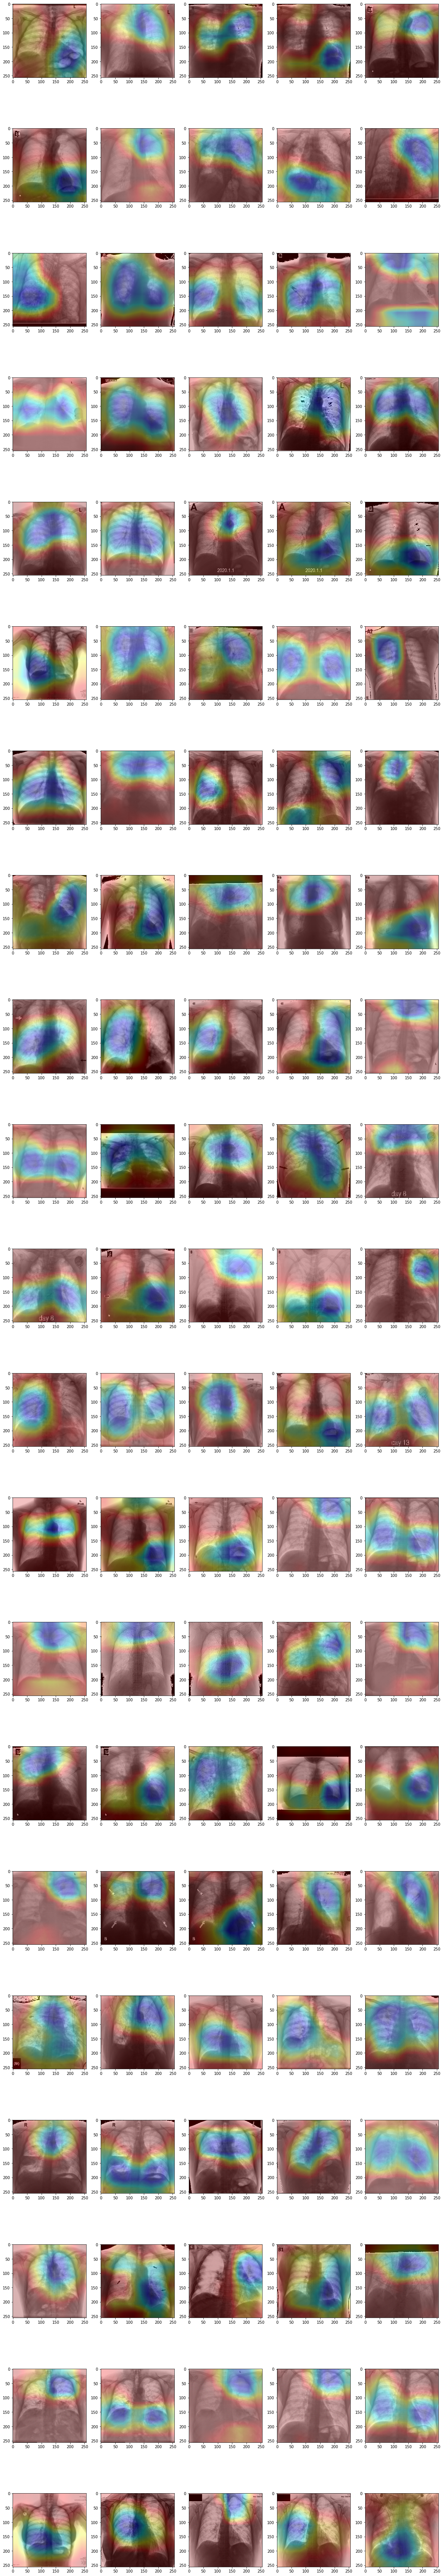

In [37]:
fig, axis = plt.subplots(21, 5, figsize=(20, 125))
for i, ax in enumerate(axis.flat):
    ax.imshow(heatmap_output_1[i]) # add image

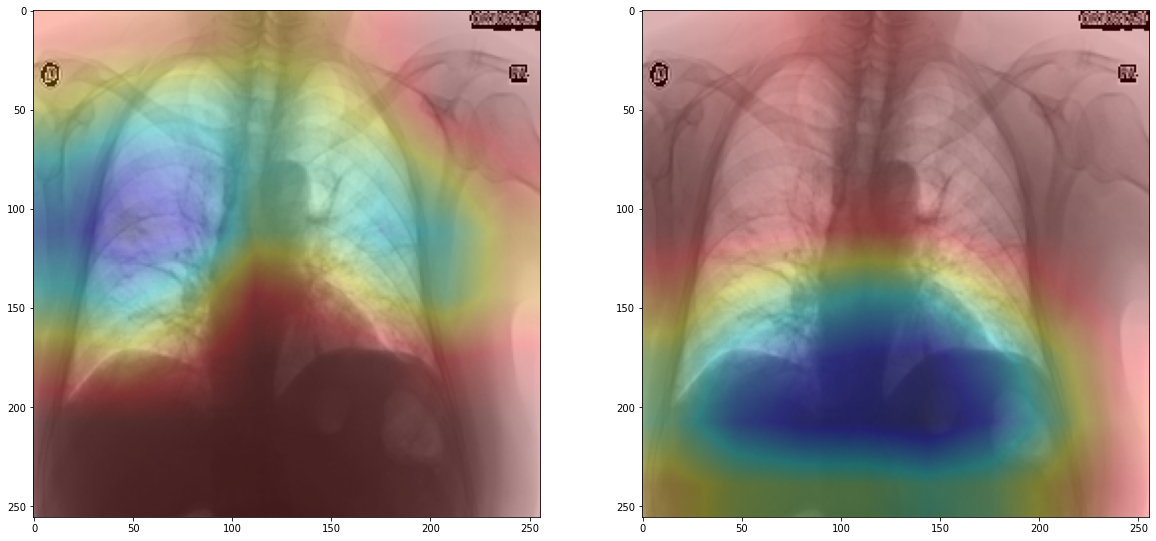

In [38]:
fig, axis = plt.subplots(1, 2, figsize=(20, 50))
for i, ax in enumerate(axis.flat):
    ax.imshow(heatmap_output_2[i]) # add image